In [1]:
import os
from glob import glob
import cv2
import numpy as np
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torch.utils.tensorboard import SummaryWriter
from torchvision import datasets, transforms, models
from torchvision.transforms import ToTensor, Resize, Compose
from PIL import Image
from collections import OrderedDict

from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class CustomDataset(Dataset):
    def __init__(self, image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
                        ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/', \
                        ref_suffix='', transform=None, target_size=(256, 256)):
        self.image_dir = image_dir
        self.ref_dir = ref_dir
        self.ref_suffix = ref_suffix
        self.target_size = target_size

        if transform is None:
            self.transform = Compose([
                Resize(self.target_size),  # Resize the image to target size
                ToTensor(),  # Convert image to tensor
            ])
        else:
            self.transform = transform

        filenames = [os.path.splitext(file)[0] for file in os.listdir(image_dir)]
        self.ids = {}
        for idx, filename in enumerate(filenames):
            self.ids[idx] = filename

    def __getitem__(self, i):
        basename = self.ids[i]

        ref_file = glob(self.ref_dir + basename + self.ref_suffix + '.*')
        img_file = glob(self.image_dir + basename + '.*')

        ref = cv2.imread(ref_file[0])
        img = cv2.imread(img_file[0])

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ref = cv2.cvtColor(ref, cv2.COLOR_BGR2RGB)
        
        # Convert NumPy arrays to PIL Images
        img = Image.fromarray(img)
        ref = Image.fromarray(ref)

        # Apply the transformation
        img = self.transform(img)
        ref = self.transform(ref)

        return img, ref

    def __len__(self):
        return len(self.ids.keys())

def print_sample_image_sizes(dataset, num_samples=10):
    """Print sizes of sample images from the dataset."""
    for i in range(min(num_samples, len(dataset))):
        img, ref = dataset[i]
        # Print transformed sizes; tensors follow (C, H, W) format.
        print(f"Sample {i+1} - Image size: {img.size()}, Reference size: {ref.size()}")

# Assuming the build_dataset function and necessary imports are defined elsewhere
# and the dataset paths are correctly specified:
dataset = CustomDataset()

# Print sizes of 10 sample images
print_sample_image_sizes(dataset, 10)


def __len__(self):
    return len(self.ids.keys())

def build_dataset(image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
                    ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/', \
                    test_split=0.15):

    dataset = CustomDataset(image_dir, ref_dir)

    tsplit = test_split
    tsize = int(len(dataset)*tsplit)
    indices = torch.randperm(len(dataset)).tolist()

    train = Subset(dataset, indices[:-tsize])
    test = Subset(dataset, indices[-tsize:])

    train_loader = DataLoader(
      train,
      batch_size=1,
      shuffle=True,
      num_workers=0
    )

    test_loader = DataLoader(
        test,
        batch_size=1,
        shuffle=True,
        num_workers=0
    )

    return train_loader, test_loader

Sample 1 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 2 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 3 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 4 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 5 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 6 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 7 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 8 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 9 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])
Sample 10 - Image size: torch.Size([3, 256, 256]), Reference size: torch.Size([3, 256, 256])


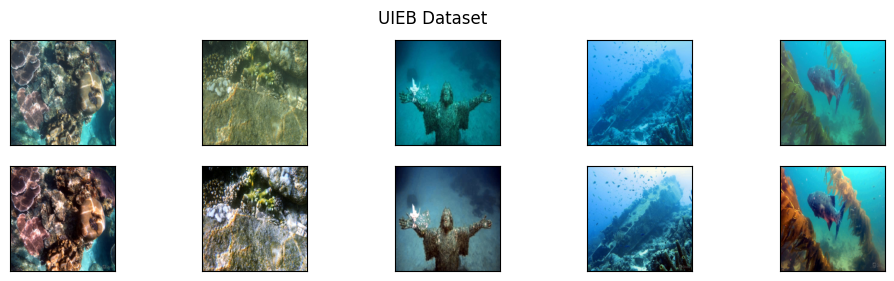

In [5]:
viz_dataset = CustomDataset(image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
                    ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/')

common_size = (720, 1280, 3)
target_width = 1280
target_height = 720
num_images = 5

fig, axes = plt.subplots(2, num_images)
fig.set_figwidth(12)
fig.set_figheight(3)
plt.suptitle('UIEB Dataset')
for idx in range(num_images):
    img, ref = viz_dataset[idx]

    # Pad the image with zeros to make it the target size
    axes[0][idx].imshow(np.transpose(img.numpy(), (1, 2, 0)))
    axes[1][idx].imshow(np.transpose(ref.numpy(), (1, 2, 0)))
#     axes[0][idx].imshow(img)
#     axes[1][idx].imshow(ref)
    axes[0][idx].set_xticks([])
    axes[0][idx].set_yticks([])
    axes[1][idx].set_xticks([])
    axes[1][idx].set_yticks([])

In [6]:
def white_balance(image, lambda_value=0.2):

    image = image.numpy()
    image = np.transpose(image, (1,2,0))
    image = image.astype(np.float32)

    scene_mean = np.mean(image)

    # Calculate lighting estimate
    lighting_estimate = 0.5 + lambda_value * scene_mean

    # Adjust the image by the lighting estimate
    balanced_image = image * (lighting_estimate / scene_mean)

    balanced_image = np.clip(balanced_image, 0.0, 1.0)

    return torch.tensor(np.transpose(balanced_image, (2,0,1)))

def clahe(img, clip_limit=2.0, grid_size=(8, 8)):

    img = np.transpose(img.numpy(), (1, 2, 0))
        
    img = cv2.convertScaleAbs(img, alpha=(65535.0/255.0))

    img = cv2.cvtColor(img, cv2.COLOR_RGB2LAB)
    l_channel, a_channel, b_channel = cv2.split(img)
    clahe = cv2.createCLAHE(clipLimit=clip_limit, tileGridSize=grid_size)
    cl_l_channel = clahe.apply(l_channel)

    clahe_img = cv2.merge((cl_l_channel, a_channel, b_channel))

    clahe_img_bgr = cv2.cvtColor(clahe_img, cv2.COLOR_LAB2RGB)

    return torch.tensor(np.transpose(clahe_img_bgr, (2,0,1)).astype(np.float32) / 255)

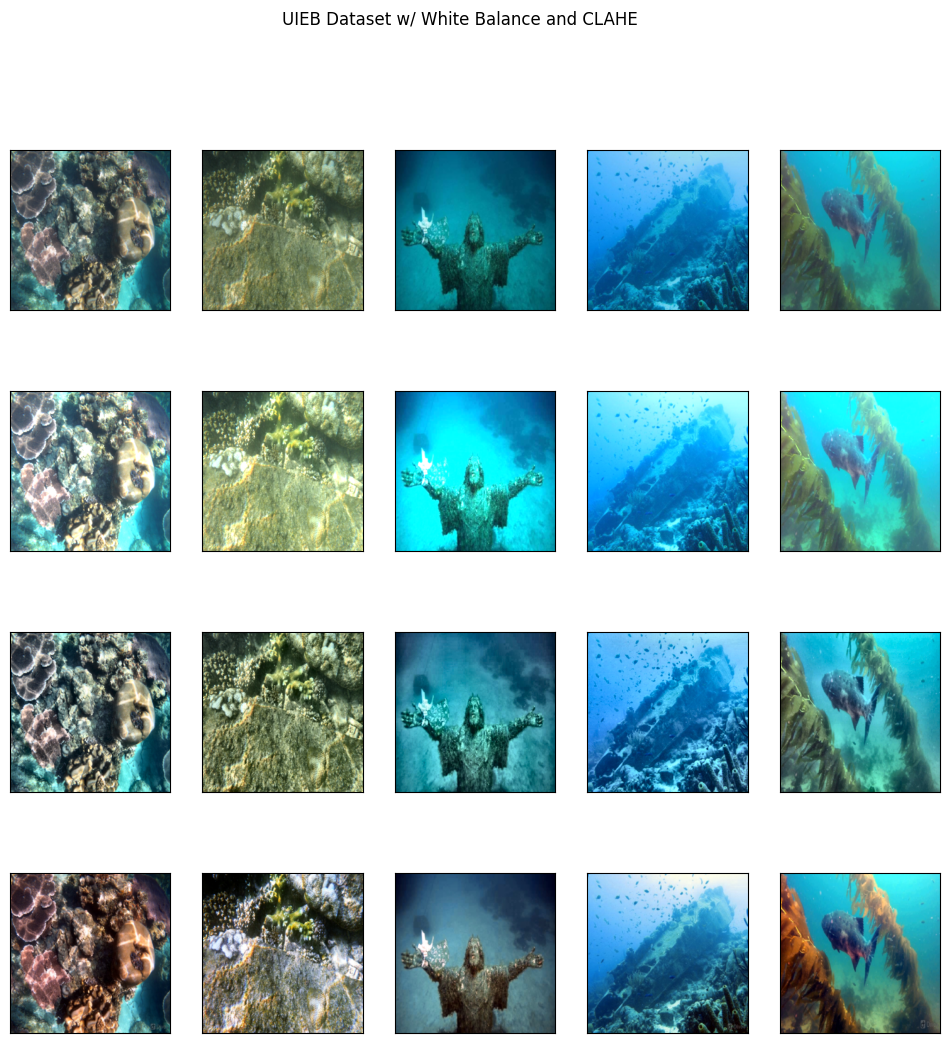

In [8]:
fig, axes = plt.subplots(4, num_images)
fig.set_figwidth(12)
fig.set_figheight(12)
plt.suptitle('UIEB Dataset w/ White Balance and CLAHE')

for idx in range(num_images):
    img, ref = viz_dataset[idx]
    wb, eq = white_balance(img), clahe(img)


    # UNCOMMENT ONCE ALL IMAGES ARE WORKING
    axes[0][idx].imshow(np.transpose(img.numpy(), (1,2,0)))
    axes[1][idx].imshow(np.transpose(wb.numpy(), (1,2,0)))
    axes[2][idx].imshow(np.transpose(eq.numpy(), (1,2,0)))
    axes[3][idx].imshow(np.transpose(ref.numpy(), (1,2,0)))
#     axes[0][idx].imshow(img)
#     axes[1][idx].imshow(wb)
#     axes[2][idx].imshow(eq)
#     axes[3][idx].imshow(ref)
    axes[0][idx].set_xticks([])
    axes[0][idx].set_yticks([])
    axes[1][idx].set_xticks([])
    axes[1][idx].set_yticks([])
    axes[2][idx].set_xticks([])
    axes[2][idx].set_yticks([])
    axes[3][idx].set_xticks([])
    axes[3][idx].set_yticks([])

In [9]:
class Placeholder(nn.Module):
    def __init__(self, in_channels = 3):
        super(Placeholder, self).__init__()
        self.conv1 = nn.Conv2d(in_channels,
                              in_channels,
                              kernel_size=3,
                              padding=1)
        self.conv2 = nn.Conv2d(in_channels,
                              in_channels,
                              kernel_size=3,
                              padding=1)
        self.conv3 = nn.Conv2d(in_channels,
                              in_channels,
                              kernel_size=3,
                              padding=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)

        return x

In [10]:
class ResidualBlock(nn.Module):
    def __init__(self, n=3):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = n, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(in_channels = 128, out_channels = 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(in_channels = 64, out_channels = n, kernel_size=3, stride=1, padding=1)

    def forward(self, x):
        x1 = x
        out = F.gelu(self.conv1(x))
        out = F.gelu(self.conv2(out))
        out = F.gelu(self.conv3(out))
        out = self.conv4(out)

        # pixel-wise addition
        out += x1
        return out

class REM(nn.Module):
    def __init__(self, n=3):
        super(REM, self).__init__()

        self.residual_block1 = ResidualBlock(n=n)
        self.residual_block2 = ResidualBlock(n=n)

    def forward(self, x):
        x = self.residual_block1(x)
        x = self.residual_block2(x)

        return x


In [13]:
class MFFModule(nn.Module):
    def __init__(self, groups):
        super(MFFModule, self).__init__()
        self.conv1x1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=1, stride=1, padding='same')
        self.conv3x3 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride=1, padding='same')
        self.conv5x5 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=5, stride=1, padding='same')
#         self.channel_shuffle = nn.ChannelShuffle(groups)
        self.final_conv3x3 = nn.Conv2d(in_channels = 3*3, out_channels = 3, kernel_size=3, stride=1, padding=1)

    def forward(self, fb1, fb2, fb3):
        f1 = F.gelu(self.conv1x1(fb1))
        f2 = F.gelu(self.conv3x3(fb2))
        f3 = F.gelu(self.conv5x5(fb3))

        # Pixel-wise addition
        f1 = f1 + fb1
        f2 = f2 + fb2
        f3 = f3 + fb3

        # Concatenate the feature maps
        f_cat = torch.cat((f1, f2, f3), dim=1)

        # Channel Shuffle
        f_shuffle = f_cat # self.channel_shuffle(f_cat)

        # Final convolution
        out = self.final_conv3x3(f_shuffle)
        return out

In [14]:
class Conv(nn.Module):
    def __init__(self):
        super(Conv, self).__init__()
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=3, stride=1, padding='same')

    def forward(self, x):
        b = self.conv1(x)
        m = F.max_pool2d(b, kernel_size=2, stride=2, padding=1)
        m = self.conv1(m)
        s = F.max_pool2d(m, kernel_size=2, stride=2, padding=1)
        s = self.conv1(s)

        return b, m, s

In [15]:
class PCAM(nn.Module):
    def __init__(self, n_size=3):
        super(PCAM, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=n_size, out_channels=n_size, kernel_size=3, stride=1, padding='same')
        self.conv2_33 = nn.Conv2d(in_channels=n_size, out_channels=n_size, kernel_size=3, stride=1, padding='same')
        self.conv2_11 = nn.Conv2d(in_channels=n_size, out_channels=n_size, kernel_size=1, stride=1, padding='same')
        self.fc1 = nn.Linear(in_features=n_size, out_features=n_size)
        self.fc2 = nn.Linear(in_features=n_size, out_features=n_size)

    def forward(self, x):
        x1 = F.gelu(self.conv1(x))

        x2_33 = self.conv2_33(x1)
        x2_11 = F.sigmoid(self.conv2_11(x1))
        x2 = x2_33 * x2_11

        x3 = torch.mean(x2.flatten(start_dim=2), dim=-1)
        x3 = F.gelu(self.fc1(x3))
        x3 = F.sigmoid(self.fc2(x3))
        x3 = x3.reshape(*x3.shape, 1, 1)

        out = x + x2 + (x3 * x1)

        return out


In [16]:
class MFEF(nn.Module):
    def __init__(self, channel_shuffle_groups=3):
        super(MFEF, self).__init__()
        self.rem1 = REM(n=3)
        self.rem2 = REM(n=3)
        self.rem3 = REM(n=3)
        self.mff1 = MFFModule(channel_shuffle_groups)
        self.mff2 = MFFModule(channel_shuffle_groups)
        self.mff3 = MFFModule(channel_shuffle_groups)

        self.rem4 = REM(n=9)
        self.rem5 = REM(n=6)
        self.rem6 = REM(n=3)
        self.rem4_conv = nn.Conv2d(in_channels = 9, out_channels = 3, kernel_size=1, stride=1, padding='same')
        self.rem5_conv = nn.Conv2d(in_channels = 6, out_channels = 3, kernel_size=1, stride=1, padding='same')
        self.rem6_conv = nn.Conv2d(in_channels = 3, out_channels = 3, kernel_size=1, stride=1, padding='same')

        self.red_conv = Conv()
        self.yellow_conv = Conv()
        self.green_conv = Conv()

        self.pcam1 = PCAM(n_size=9)
        self.pcam2 = PCAM(n_size=9)
        self.pcam3 = PCAM(n_size=9)

        self.rem7 = REM(n=27)
        self.rem8 = REM(n=18)
        self.rem9 = REM(n=9)

        self.out_conv = nn.Conv2d(in_channels = 27, out_channels = 3, kernel_size=3, stride=1, padding='same')

    def forward(self, image, wb, clahe):
        # Residual Block One
        rem1_out = self.rem1(image)
        rem2_out = self.rem2(wb)
        rem3_out = self.rem3(clahe)

        # MFF Block
        mff1_out  = self.mff1(rem1_out, rem2_out, rem3_out)
        mff2_out  = self.mff2(rem1_out, rem2_out, rem3_out)
        mff3_out  = self.mff3(rem1_out, rem2_out, rem3_out)

        # Residual Block Two
        rem6_out = self.rem6(mff3_out)
        rem5_out = self.rem5(torch.concat([mff2_out, rem6_out], axis=1))
        rem4_out = self.rem4(torch.concat([mff1_out, rem5_out], axis=1))

        rem4_out = self.rem4_conv(rem4_out)
        rem5_out = self.rem5_conv(rem5_out)
        rem6_out = self.rem6_conv(rem6_out)

        red_in = rem4_out + image
        yellow_in = rem5_out + wb
        green_in = rem6_out + clahe

        Rb, Rm, Rs = self.red_conv(red_in)
        Yb, Ym, Ys = self.yellow_conv(yellow_in)
        Gb, Gm, Gs = self.green_conv(green_in)

        b_cat = torch.cat((Rb, Yb, Gb), dim=1)
        m_cat = torch.cat((Rm, Ym, Gm), dim=1)
        s_cat = torch.cat((Rs, Ys, Gs), dim=1)

        pcam1_out = self.pcam1(b_cat)
        pcam2_out = self.pcam2(m_cat)
        pcam3_out = self.pcam3(s_cat)

        rem9_out = self.rem9(pcam3_out)
        rem9_out_scaled = F.interpolate(rem9_out, scale_factor=2)
        # This is dumb, find better way to do this
        if rem9_out_scaled.shape[2] != pcam2_out.shape[2]:
            rem9_out_scaled = rem9_out_scaled[:, :, :pcam2_out.shape[2]]
        if rem9_out_scaled.shape[3] != pcam2_out.shape[3]:
            rem9_out_scaled = rem9_out_scaled[:, :, :, :pcam2_out.shape[3]]
        rem8_out = self.rem8(torch.concat([pcam2_out, rem9_out_scaled], axis=1))
        rem8_out_scaled = F.interpolate(rem8_out, scale_factor=2)
        # This is dumb, find better way to do this
        if rem8_out_scaled.shape[2] != pcam1_out.shape[2]:
            rem8_out_scaled = rem8_out_scaled[:, :, :pcam1_out.shape[2]]
        if rem8_out_scaled.shape[3] != pcam1_out.shape[3]:
            rem8_out_scaled = rem8_out_scaled[:, :, :, :pcam1_out.shape[3]]
        rem7_out = self.rem7(torch.concat([pcam1_out, rem8_out_scaled], axis=1))
        out = self.out_conv(rem7_out)

        return out

In [21]:
model = MFEF()
model.load_state_dict(torch.load("/kaggle/input/best-weights/best_089_79936.pth"))

<All keys matched successfully>

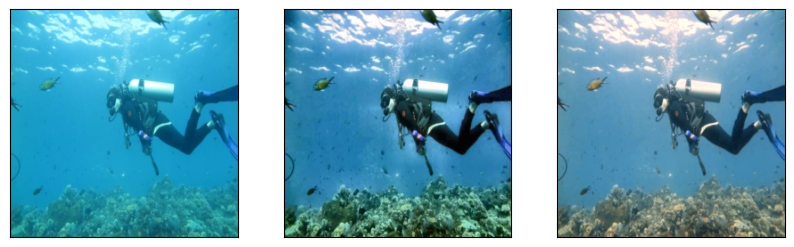

In [36]:
num_images = 30
fig, axes = plt.subplots(1, 3)
fig.set_figwidth(10)
fig.set_figheight(3)
# plt.suptitle('UIEB Dataset w/ White Balance and CLAHE')

save_path = "/kaggle/working"
for idx in range(num_images):
    img, ref = viz_dataset[idx]
    wb, eq = white_balance(img).unsqueeze(dim=0), clahe(img).unsqueeze(dim=0)
    img, ref = img.unsqueeze(dim=0), ref.unsqueeze(dim=0)

    out = model(img, wb, eq)
    

    # UNCOMMENT ONCE ALL IMAGES ARE WORKING
    axes[0].imshow(np.transpose(img.squeeze(dim=0).numpy(), (1,2,0)))
    axes[1].imshow(np.transpose(ref.squeeze(dim=0).numpy(), (1,2,0)))
    axes[2].imshow(np.transpose(out.squeeze(dim=0).detach().numpy(), (1,2,0)))
    axes[0].set_xticks([])
    axes[0].set_yticks([])
    axes[1].set_xticks([])
    axes[1].set_yticks([])
    axes[2].set_xticks([])
    axes[2].set_yticks([])
    
    filename = os.path.join(save_path, str(idx) + "_viz.png")
    fig.savefig(filename)

In [ ]:
LAYERS = [64, 64, "M", \
          128, 128, "M", \
          256, 256, 256, "M", \
          512, 512, 512, "M", \
          512, 512, 512, "M"]

layer2layer = {
    "conv1.weight" : "features.0.weight", "conv1.bias": "features.0.bias",
    "conv2.weight" : "features.2.weight", "conv2.bias": "features.2.bias",
    "conv3.weight" : "features.5.weight", "conv3.bias": "features.5.bias",
    "conv4.weight" : "features.7.weight", "conv4.bias": "features.7.bias",
    "conv5.weight" : "features.10.weight", "conv5.bias": "features.10.bias",
    "conv6.weight" : "features.12.weight", "conv6.bias": "features.12.bias",
    "conv7.weight" : "features.14.weight", "conv7.bias": "features.14.bias",
    "conv8.weight" : "features.17.weight", "conv8.bias": "features.17.bias",
    "conv9.weight" : "features.19.weight", "conv9.bias": "features.19.bias",
    "conv10.weight" : "features.21.weight", "conv10.bias": "features.21.bias",
    "conv11.weight" : "features.24.weight", "conv11.bias": "features.24.bias",
    "conv12.weight" : "features.26.weight", "conv12.bias": "features.26.bias",
    "conv13.weight" : "features.28.weight", "conv13.bias": "features.28.bias",

}
layer2layer = {value: key for key, value in layer2layer.items()}

class VGG(nn.Module):
    def __init__(self, in_channels = 3) -> None:
        super().__init__()
        self.maxpool = nn.MaxPool2d(kernel_size=2, stride=2)
        # self.bn64 = nn.BatchNorm2d(64)
        # self.bn128 = nn.BatchNorm2d(128)
        # self.bn256 = nn.BatchNorm2d(256)
        # self.bn512 = nn.BatchNorm2d(512)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(in_channels, 64, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.conv4 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.conv5 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.conv6 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv7 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.conv8 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.conv9 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv10 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv11 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.conv13 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

    def ConvBNReLU(self, conv, bn, x):
        x = conv(x)
        x = bn(x)
        x = self.relu(x)
        return x

    def ConvReLU(self, conv, x):
        x = conv(x)
        x = self.relu(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        out = []
        # Phase One
        x = self.ConvReLU(self.conv1, x)
        out.append(x)
        x = self.ConvReLU(self.conv2, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Two
        x = self.ConvReLU(self.conv3, x)
        out.append(x)
        x = self.ConvReLU(self.conv4, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Three
        x = self.ConvReLU(self.conv5, x)
        out.append(x)
        x = self.ConvReLU(self.conv6, x)
        out.append(x)
        x = self.ConvReLU(self.conv7, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Four
        x = self.ConvReLU(self.conv8, x)
        out.append(x)
        x = self.ConvReLU(self.conv9, x)
        out.append(x)
        x = self.ConvReLU(self.conv10, x)
        out.append(x)
        x = self.maxpool(x)

        # Phase Five
        x = self.ConvReLU(self.conv11, x)
        out.append(x)
        x = self.ConvReLU(self.conv12, x)
        out.append(x)
        x = self.ConvReLU(self.conv13, x)
        out.append(x)
        x = self.maxpool(x)

        return out

vgg = VGG()
vgg_weights = torch.load("/kaggle/input/vgg16-397923af-pth/vgg16-397923af.pth")
vgg_weights = OrderedDict({layer2layer[k]: v for k, v in vgg_weights.items() if k in layer2layer.keys()})
vgg.load_state_dict(vgg_weights)

In [ ]:
class LossFunc(nn.Module):
    def forward(self, pred, target, model):
        target_out = model(target)
        pred_out = model(pred)
        model_loss = 0
        for target_layer, pred_layer in zip(target_out, pred_out):
            model_loss += torch.sum(torch.abs(target_layer - pred_layer))
        l1_loss = torch.mean(torch.abs(target - pred))
        return l1_loss + 0.05*model_loss

In [ ]:
!nvidia-smi

In [ ]:
EPOCHS = 200
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
loss_func = LossFunc()
print_every = 150
test_losses, train_losses = [], []
train_loader, test_loader = build_dataset()
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

In [ ]:
model.to(device)
vgg.to(device)

In [ ]:
print("Model loaded on", next(model.parameters()).device)
print("VGG loaded on", next(vgg.parameters()).device)

In [ ]:
def prep_wb_eq(image):
    wb, eq = white_balance(image.cpu()[0]), clahe(image.cpu()[0])
    wb, eq = wb.unsqueeze(dim=0), eq.unsqueeze(dim=0)
    wb, eq = wb.to(device), eq.to(device)
    
    return wb, eq

In [ ]:
best_loss = 99999999.0
for e in range(EPOCHS):
    running_loss = 0
    step = 0
    for image, label in train_loader:
        wb, eq = prep_wb_eq(image)
        image, label = image.to(device), label.to(device)
        step += 1
        optimizer.zero_grad()
        out = model(image, wb, eq)
        loss = loss_func(out, label, vgg)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        if step % print_every == 0:
            test_loss = 0
            accuracy = 0

            with torch.no_grad():
                # model -> eval means gradients aren't calculated + no backprop
                model.eval()
                for image, label in test_loader:
                    wb, eq = prep_wb_eq(image)
                    image, label = image.to(device), label.to(device)
                    out = model(image, wb, eq)
                    loss = loss_func(out, label, vgg)
                    test_loss += loss.item()
                # model -> train means gradients are calculated + backprop
                model.train()
                
                train_losses.append(running_loss/print_every)
                test_losses.append(test_loss/len(test_loader))

                if test_losses[-1] < best_loss:
                    if not os.path.isdir("/kaggle/working/weights"):
                        os.mkdir("/kaggle/working/weights")
                    filename = f"best_{e:03d}_{int(test_losses[-1])}.pth"
                    torch.save(model.state_dict(), os.path.join("/kaggle/working/weights", filename))
                
                print("Epoch: {}/{}.. ".format(e+1, EPOCHS),
                      "Training Loss: {:.3f}.. ".format(train_losses[-1]),
                      "Test Loss: {:.3f}.. ".format(test_losses[-1]))

                running_loss = 0

print("Done Training...")

In [2]:
files = []
for file in os.listdir("/kaggle/working/weights"):
    files.append(file)

files.sort()
print(files)

# for file in os.listdir("/kaggle/working/weights"):
#     print("Removing", file)
#     os.remove(os.path.join("/kaggle/working/weights", file))

FileNotFoundError: [Errno 2] No such file or directory: '/kaggle/working/weights'

In [ ]:
import scipy.signal

'''MIT License

Copyright (c) 2021 Xuelei Chen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.'''


# source: https://github.com/deepxzy/PCQI-python/blob/master/pcqi.py
def PCQI(img1, img2):
    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    window = window / np.sum(np.sum(window))

    mu1 = scipy.signal.correlate2d(img1, window, 'valid')
    mu2 = scipy.signal.correlate2d(img2, window, 'valid')
    mu1_sq = mu1 * mu1

    mu2_sq = mu2 * mu2
    mu1_mu2 = mu1 * mu2


    sigma1_sq = scipy.signal.correlate2d(img1 * img1, window, 'valid')- mu1_sq
    sigma2_sq = scipy.signal.correlate2d(img2 * img2, window, 'valid') - mu2_sq
    sigma12 = scipy.signal.correlate2d(img1 * img2, window, 'valid') - mu1_mu2

    sigma1_sq[sigma1_sq<0]=0
    sigma2_sq[sigma2_sq<0]=0


    C = 3

    pcqi_map = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
    pcqi_map = pcqi_map * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
    pcqi_map = pcqi_map * np.exp(-abs(mu1 - mu2) / L)

    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map

def PCQI_3d(img1, img2):
    window = np.multiply(cv2.getGaussianKernel(11, 1.5), (cv2.getGaussianKernel(11, 1.5)).T)

    L = 256

    window = window / np.sum(np.sum(window))

    pcqi_map_channels = []

    # Iterate over each channel
    for channel in range(3):
        img1_channel = img1[:,:,channel]
        img2_channel = img2[:,:,channel]

        mu1 = scipy.signal.correlate2d(img1_channel, window, 'valid')
        mu2 = scipy.signal.correlate2d(img2_channel, window, 'valid')

        mu1_sq = mu1 * mu1
        mu2_sq = mu2 * mu2
        mu1_mu2 = mu1 * mu2

        sigma1_sq = scipy.signal.correlate2d(img1_channel * img1_channel, window, 'valid') - mu1_sq
        sigma2_sq = scipy.signal.correlate2d(img2_channel * img2_channel, window, 'valid') - mu2_sq
        sigma12 = scipy.signal.correlate2d(img1_channel * img2_channel, window, 'valid') - mu1_mu2

        sigma1_sq[sigma1_sq < 0] = 0
        sigma2_sq[sigma2_sq < 0] = 0

        C = 3

        pcqi_map_channel = (4 / np.pi) * np.arctan((sigma12 + C) / (sigma1_sq + C))
        pcqi_map_channel = pcqi_map_channel * ((sigma12 + C) / (np.sqrt(sigma1_sq) * np.sqrt(sigma2_sq) + C))
        pcqi_map_channel = pcqi_map_channel * np.exp(-abs(mu1 - mu2) / L)

        pcqi_map_channels.append(pcqi_map_channel)

    # Average PCQI across channels
    pcqi_map = np.mean(pcqi_map_channels, axis=0)
    mpcqi = np.mean(pcqi_map)

    return mpcqi, pcqi_map            


In [ ]:
'''MIT License

Copyright (c) 2021 Xuelei Chen

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.'''

'''
Metrics for underwater image quality evaluation.

Author: Xuelei Chen 
Email: chenxuelei@hotmail.com

Usage:
python evaluate.py RESULT_PATH REFERENCE_PATH

Source: https://github.com/xueleichen/PSNR-SSIM-UCIQE-UIQM-Python/blob/main/evaluate.py
'''
import numpy as np
import math
import sys
from skimage import io, color, filters
import os
import math

def nmetrics(a):
    a = cv2.normalize(a, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    rgb = a
    lab = color.rgb2lab(a)
    gray = color.rgb2gray(a)
    # UCIQE
    c1 = 0.4680
    c2 = 0.2745
    c3 = 0.2576
    l = lab[:,:,0]

    #1st term
    chroma = (lab[:,:,1]**2 + lab[:,:,2]**2)**0.5
    uc = np.mean(chroma)
    sc = (np.mean((chroma - uc)**2))**0.5

    #2nd term
    top = int(np.round(0.01*l.shape[0]*l.shape[1]))
    sl = np.sort(l,axis=None)
    isl = sl[::-1]
    conl = np.mean(isl[:top])-np.mean(sl[:top])

    #3rd term
    satur = []
    chroma1 = chroma.flatten()
    l1 = l.flatten()
    for i in range(len(l1)):
        if chroma1[i] == 0: satur.append(0)
        elif l1[i] == 0: satur.append(0)
        else: satur.append(chroma1[i] / l1[i])

    us = np.mean(satur)

    uciqe = c1 * sc + c2 * conl + c3 * us

    # UIQM
    p1 = 0.0282
    p2 = 0.2953
    p3 = 3.5753

    #1st term UICM
    rg = rgb[:,:,0] - rgb[:,:,1]
    yb = (rgb[:,:,0] + rgb[:,:,1]) / 2 - rgb[:,:,2]
    rgl = np.sort(rg,axis=None)
    ybl = np.sort(yb,axis=None)
    al1 = 0.1
    al2 = 0.1
    T1 = int(al1 * len(rgl))
    T2 = int(al2 * len(rgl))
    rgl_tr = rgl[T1:-T2]
    ybl_tr = ybl[T1:-T2]

    urg = np.mean(rgl_tr)
    s2rg = np.mean((rgl_tr - urg) ** 2)
    uyb = np.mean(ybl_tr)
    s2yb = np.mean((ybl_tr- uyb) ** 2)

    uicm =-0.0268 * np.sqrt(urg**2 + uyb**2) + 0.1586 * np.sqrt(s2rg + s2yb)

    #2nd term UISM (k1k2=8x8)
    Rsobel = rgb[:,:,0] * filters.sobel(rgb[:,:,0])
    Gsobel = rgb[:,:,1] * filters.sobel(rgb[:,:,1])
    Bsobel = rgb[:,:,2] * filters.sobel(rgb[:,:,2])

    Rsobel=np.round(Rsobel).astype(np.uint8)
    Gsobel=np.round(Gsobel).astype(np.uint8)
    Bsobel=np.round(Bsobel).astype(np.uint8)

    Reme = eme(Rsobel)
    Geme = eme(Gsobel)
    Beme = eme(Bsobel)

    uism = 0.299 * Reme + 0.587 * Geme + 0.114 * Beme

    #3rd term UIConM
    uiconm = logamee(gray)

    uiqm = p1 * uicm + p2 * uism + p3 * uiconm
    return uiqm,uciqe

def eme(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    eme = 0
    w = 2. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]

            blockmin = np.float64(np.min(block))
            blockmax = np.float64(np.max(block))

            # # old version
            # if blockmin == 0.0: eme += 0
            # elif blockmax == 0.0: eme += 0
            # else: eme += w * math.log(blockmax / blockmin)

            # new version
            if blockmin == 0: blockmin+=1
            if blockmax == 0: blockmax+=1
            eme += w * math.log(blockmax / blockmin)
    return eme

def plipsum(i,j,gamma=1026):
    return i + j - i * j / gamma

def plipsub(i,j,k=1026):
    return k * (i - j) / (k - j)

def plipmult(c,j,gamma=1026):
    return gamma - gamma * (1 - j / gamma)**c

def logamee(ch,blocksize=8):

    num_x = math.ceil(ch.shape[0] / blocksize)
    num_y = math.ceil(ch.shape[1] / blocksize)
    
    s = 0
    w = 1. / (num_x * num_y)
    for i in range(num_x):

        xlb = i * blocksize
        if i < num_x - 1:
            xrb = (i+1) * blocksize
        else:
            xrb = ch.shape[0]

        for j in range(num_y):

            ylb = j * blocksize
            if j < num_y - 1:
                yrb = (j+1) * blocksize
            else:
                yrb = ch.shape[1]
            
            block = ch[xlb:xrb,ylb:yrb]
            blockmin = np.float64(np.min(block))
            blockmax = np.float64(np.max(block))

            top = plipsub(blockmax,blockmin)
            bottom = plipsum(blockmax,blockmin)

            m = top/bottom
            if m ==0.:
                s+=0
            else:
                s += (m) * np.log(m)

    return plipmult(w,s)

In [ ]:
import math
from skimage.metrics import structural_similarity as SSIM
from skimage.metrics import peak_signal_noise_ratio as PSNR
from scipy import stats

def compute_PSNR(img1, img2):
    """
    Calculate the Peak Signal-to-Noise Ratio (PSNR) between two given images.
    
    Parameters:
        img1 (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        img2 (numpy.ndarray): Reference image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: PSNR value for the input image.
    """
    #img1 = normalize_image_1(img1)
    #img2 = normalize_image_1(img2)
    

    return PSNR(img1,img2)

def compute_SSIM(img1, img2):
    """
    Calculate the Structural Similarity Index (SSIM) between two given images.
    
    Parameters:
        img1 (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        img2 (numpy.ndarray): Reference image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: SSIM value for the input image.
    """
    
    #img1 = normalize_image_1(img1)
    #img2 = normalize_image_1(img2)
    
    return SSIM(img1, img2, multichannel=True, channel_axis=2, data_range=1.0)


def compute_PCQI(img1, img2):
    '''
    Calculate the Pixel Compressed Quality Index (PCQI) between two images.
    
    Parameters:
        img1 (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        img2 (numpy.ndarray): Reference image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: PCQI value for the input image.
    '''
    
    if len(img1.shape) == 3 and img1.shape[2] == 3:
        return PCQI_3d(img1, img2)
    elif len(img1.shape) == 2 and img1.shape[2] == 1:
        return PCQI(img1, img2)
    else:
        raise ValueError("Invalid input shape. Expected 2D or 3D image with 3 channels.")
    
def compute_UCIQE(image): # Underwater colour image quality evaluation
    '''
    Calculate the Underwater Colour Image Quality Evaluation (UCIQE) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: UCIQE value for the input image.
    '''
    
    #image = image.astype(np.float32) / 255.0  # Normalize to [0, 1]
    
    image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    
    # Convert from BGR to RGB
    img_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Convert RGB to LAB
    img_lab = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2LAB)
    
    # Extract luminance, a, and b channels
    l_channel, a_channel, b_channel = cv2.split(img_lab)
    
    # Compute standard deviation of chroma (σc)
    chroma_std = np.std(np.sqrt(np.square(a_channel) + np.square(b_channel)))
    
    # Compute contrast of luminance (conl)
    bottom_percentile = np.percentile(l_channel, 1)
    top_percentile = np.percentile(l_channel, 99)
    contrast_luminance = top_percentile - bottom_percentile
    
    # Compute average saturation (μs)
    saturation_avg = np.mean(np.sqrt(np.square(a_channel) + np.square(b_channel)))
    
    # Coefficients
    c1 = 0.4680
    c2 = 0.2745
    c3 = 0.2576
    
    # Calculate UCIQE
    UCIQE_score = c1 * chroma_std + c2 * contrast_luminance + c3 * saturation_avg
    
    return UCIQE_score
    
def compute_UICM(image):
    """
    Calculate the Underwater Image Colorfulness Measure (UICM) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: UICM value for the input image.
    """
    # Convert image to float and normalize it to the range [0, 1]
    #image = image.astype(np.float32) / 255.0
    
    # Convert from BGR to RGB
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    R = image[:,:,0]
    G = image[:,:,1]
    B = image[:,:,2]
    
    RG = R - G
    
    YB = (R + G)/2 - B
    
    a_l, a_r = 0,0
    
    # Calculate mean value of each color channel
    R_mean = np.mean(image[:, :, 0])
    G_mean = np.mean(image[:, :, 1])
    B_mean = np.mean(image[:, :, 2])
    
    # Calculate standard deviation of each color channel
    R_std = np.std(image[:, :, 0])
    G_std = np.std(image[:, :, 1])
    B_std = np.std(image[:, :, 2])
    
    # Calculate colorfulness for each channel
    R_colorfulness = (R_std + 0.3) / (R_mean + 0.3)
    G_colorfulness = (G_std + 0.3) / (G_mean + 0.3)
    B_colorfulness = (B_std + 0.3) / (B_mean + 0.3)
    
    # Calculate overall colorfulness
    UICM = np.sqrt(R_colorfulness**2 + G_colorfulness**2 + B_colorfulness**2)
    
    return UICM

# Example usage:
# Load an image using a library like OpenCV or PIL
# Then pass the image to the uicm function
# For example:
# import cv2
# image = cv2.imread("example.jpg")
# uicm_value = uicm(image)

def compute_UISM(image):
    """
    Calculate the Underwater Image Sharpness Measure (UISM) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: UISM value for the input image.
    """
    
    #image = image.astype(np.float32) / 255.0
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate the gradient magnitude using Scharr operator
    grad_x = cv2.Scharr(gray, cv2.CV_32F, 1, 0)
    grad_y = cv2.Scharr(gray, cv2.CV_32F, 0, 1)
    grad_mag = cv2.magnitude(grad_x, grad_y)
    
    # Calculate the average gradient magnitude
    uism_value = np.mean(grad_mag)
    
    return uism_value

def compute_UIconM(image):
    """
    Calculate the Underwater Image Contrast Measure (UIConM) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: UIConM value for the input image.
    """
    
    #image = image.astype(np.float32) / 255.0
    
    # Convert the image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Calculate the standard deviation of pixel intensities
    uiconm_value = np.std(gray)
    
    return uiconm_value

# Example usage:
# Load an image using OpenCV
# For example:
# image = cv2.imread("example.jpg")
# Calculate UISM and UIConM values
# uism_value = uism(image)
# uiconm_value = uiconm(image)
    
def compute_UIQM(image):
    """
    Calculate the Underwater Image Quality Measure (UIQM) for a given image.
    
    Parameters:
        image (numpy.ndarray): Input image as a numpy array with shape (height, width, 3).
        
    Returns:
        float: UIQM value for the input image.
    """
    image = cv2.normalize(image, None, 0, 1, cv2.NORM_MINMAX, dtype=cv2.CV_32F)

    # Calculate UISM, UIConM, and UICM values
    uism_value = compute_UISM(image)
    uiconm_value = compute_UIconM(image)
    uicm_value = compute_UICM(image)
    
    # Calculate UIQM using weighted sum of the three measures
    uiqm_value = 0.0282 * uicm_value + 0.2953 * uism_value + 3.5753 * uiconm_value
    
    return uiqm_value

In [ ]:
model = MFEF()

model.to(device)

model.load_state_dict(torch.load("/kaggle/input/mfef/pytorch/mfef/1/best_089_79936.pth",map_location=torch.device('cpu')))

# inference_images = CustomDataset(image_dir='/kaggle/input/uieb-dataset-raw/raw-890/', \
#                     ref_dir='/kaggle/input/uieb-dataset-reference/reference-890/')

N_images = len(test_loader)

N = N_images

print(f"Infering on {N} images")

metrics = np.zeros((N,5)) # psnr, ssim, pcqi, uciqe, uiqm
# get outputs
for i,(raw_image, label_image) in tqdm(enumerate(test_loader)):
    # Obtain output from model
    #raw_image,label_image = inference_images[i]
    raw_image, label_image = np.squeeze(raw_image, axis=0), np.squeeze(label_image, axis=0)
    wb_image = white_balance(raw_image)
    eq_image = clahe(raw_image)
    raw_image, wb_image, eq_image = raw_image.unsqueeze(dim=0), wb_image.unsqueeze(dim=0), eq_image.unsqueeze(dim=0)
    raw_image, wb_image, eq_image, label_image = raw_image.to(device), wb_image.to(device), eq_image.to(device), label_image.to(device)
    out_image = model(raw_image, wb_image, eq_image)
    
    
    #image_sets.append([raw_image, wb_image, eq_image, out_image])

    # Calculate metrics for each image
    raw_image, out_image, label_image = raw_image.numpy(), out_image.detach().numpy(), label_image.numpy()        
    raw_image, out_image = np.squeeze(raw_image, axis=0), np.squeeze(out_image, axis=0)
    raw_image, out_image, label_image = np.transpose(raw_image,(1,2,0)), np.transpose(out_image,(1,2,0)), np.transpose(label_image,(1,2,0))
    
    #plot_images(raw_image, out_image)
    
    psnr = compute_PSNR(raw_image, out_image)
    ssim = compute_SSIM(raw_image, out_image)
    pcqi,_ = PCQI_3d(raw_image, out_image)
    uciqe, uiqm = nmetrics(out_image) 
    uciqe = -uciqe
    
    metrics[i,:] = np.array([psnr,ssim,pcqi,uciqe,uiqm])
    
#     print("Metrics for image",i)
#     print(f"psnr: {psnr}")
#     print(f"ssim: {ssim}")
#     print(f"pcqi: {pcqi}")
#     print(f"uciqe: {uciqe}")
#     print(f"uiqm: {uiqm}")

mean_metrics = np.mean(metrics,axis=1)
    
    

In [ ]:

def plot_images(image1, image2):
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots

    # Plot the first image (raw image) on the left subplot
    axes[0].imshow(image1)
    axes[0].set_title('Raw Image')
    axes[0].axis('off')  # Turn off axis
    axes[0].set_aspect('equal')  # Ensure aspect ratio is maintained

    # Plot the second image (output image) on the right subplot
    axes[1].imshow(image2)
    axes[1].set_title('Output Image')
    axes[1].axis('off')  # Turn off axis
    axes[1].set_aspect('equal')  # Ensure aspect ratio is maintained

    plt.show()

In [ ]:
fig, axes = plt.subplots(1, 5)

fig.set_figwidth(50)

metrics[:,3] = metrics[:,3]

axes[1].hist(metrics[:,0], bins=50)
axes[1].set_title('PSNR')
axes[1].set_xlabel('Value')
axes[1].set_ylabel('Frequency')

axes[0].hist(metrics[:,1], bins=50)
axes[0].set_title('SSIM')
axes[0].set_xlabel('Value')
axes[0].set_ylabel('Frequency')

axes[2].hist(metrics[:,2], bins=50)
axes[2].set_title('PCQI')
axes[2].set_xlabel('Value')
axes[2].set_ylabel('Frequency')

axes[3].hist(metrics[:,3], bins=50)
axes[3].set_title('UCIQE')
axes[3].set_xlabel('Value')
axes[3].set_ylabel('Frequency')

axes[4].hist(metrics[:,4], bins=50)
axes[4].set_title('UIQM')
axes[4].set_xlabel('Value')
axes[4].set_ylabel('Frequency')

print(f"mean PSNR: {np.mean(metrics[:,0])}")    
print(f"mean SSIM: {np.mean(metrics[:,1])}")
print(f"mean PCQI: {np.mean(metrics[:,2])}")
print(f"mean UCIQE: {np.mean(metrics[:,3])}")
print(f"mean UIQM: {np.mean(metrics[:,4])}")

plt.savefig('/kaggle/working/sample_plot.png')